## CSC 177-02 Data Warehousing and Data Mining
### Mini-Project 1: Clustering
### 2016 US presedential election Twitter analysis

#### Group members: Aaron Enberg,

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    preprocessing,  
    cluster as sk_cluster
)
import sklearn.feature_extraction.text as sk_text
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [107]:
column_names = ['name', 'screen_name', 'user_id', 
                'followers_count', 'friends_count', 
                'location', 'description', 'created_at', 
                'status_id', 'language', 'place', 
                'retweet_count', 'favorite_count', 'text']

tweets = pd.read_table('data/clinton_trump_tweets.txt', names=column_names, encoding='ISO-8859-1')

In [108]:
print(tweets.shape)
print(tweets.dtypes)

(5250980, 14)
name               object
screen_name        object
user_id            int64 
followers_count    int64 
friends_count      int64 
location           object
description        object
created_at         object
status_id          int64 
language           object
place              object
retweet_count      int64 
favorite_count     int64 
text               object
dtype: object


## Preprocessing

In [109]:
tweets.drop(['name', 'screen_name', 
            'followers_count', 
            'friends_count', 
            'location', 
            'description', 
            'created_at',
            'status_id', 
            'language', 
            'place', 
            'retweet_count', 
            'favorite_count'], axis=1, inplace=True)

tweets.head()

,user_id,text
0,1519696717,@NWAJimmy I've read it now though brother. Was pretty spot on Lots of bright spots but a lot to work on. Exactly as an exhibition should be!
1,109945090,RT @wikileaks: New poll puts Pirate Party on course to win Iceland's national elections on Saturday. https://t.co/edTqjeJaQ6
2,1450086582,@gaystoner821 I think New Orleans spoiled me with food. I need to try and branch out in BR.
3,167177185,RT @LOLGOP: ACA needs fixes but know da facts: *70% can get covered in marketplaces for under $75/month *Hikes affect 3% *GOP will uninsu
4,1191022351,RT @FastCompany: Alphabet shares soar on better-than-expected earnings as mobile video strategy pays off https://t.co/bokbXngMJt https://t.


### Remove all retweets

In [110]:
# lines that start with "RT" followed by a space
pattern = r'^RT\s'
 
# matches retweets and removes them
tweets = tweets[tweets.text.str.match(pattern) == False]

In [111]:
tweets.shape

(2416818, 2)

### Extract all handles and hashtags per tweet

In [112]:
# match all hashtags and handles in a tweet, ignoring possible email addresses
pattern = r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z_]+[A-Za-z0-9_]+)|(?<=^|(?<=[^a-zA-Z0-9-\.]))#([A-Za-z_]+[A-Za-z0-9_]+)'

""" returns a DataFrame with a MultiIndex:
    First index is our original index. Second index is "match" which is a running
    total of the number of occurences of hashtags and mentions for a particular 
    tweet. """
handles_hashtags = tweets.text.str.extractall(pattern)

# make the dataframe look nice 
handles_hashtags.columns = ['handles', 'hashtags']
handles_hashtags = handles_hashtags.reset_index().set_index('level_0')
del handles_hashtags.index.name
handles_hashtags.drop(['match'], axis=1, inplace=True)

# stack handles and hashtags into one column
handles_hashtags = pd.concat([handles_hashtags.handles, handles_hashtags.hashtags]).dropna().to_frame(name='handles_hashtags')

tweets = tweets.join(handles_hashtags, how='inner').reset_index()
tweets.drop(['text'], axis=1, inplace=True)

In [113]:
tweets.head(n=10)

,index,user_id,handles_hashtags
0,0,1519696717,NWAJimmy
1,2,1450086582,gaystoner821
2,6,106568768,infosec
3,6,106568768,Intel
4,6,106568768,ACM
5,6,106568768,IEEE
6,12,163712593,Haylie_Bre
7,13,2447279666,WayneDupreeShow
8,13,2447279666,climatechange
9,22,111679943,tansleyemiley69


### keep active users with at least 20 distinct hashtags/handles

In [114]:
# returns users along with the distinct hashtags/handles they've used
handles_hashtags_distinct = tweets.groupby('user_id')['handles_hashtags'].unique().to_frame()
# retrieve only those who have used 20 or more distinct handles/hashtags
users_active = handles_hashtags_distinct[handles_hashtags_distinct.handles_hashtags.str.len() > 19]

In [115]:
''' returns users along with all the hashtags and handles (including duplicates) they've used 
    (each occurrence of a hashtag/handle will also show up in the list) '''
handles_hashtags_all = tweets.reset_index().groupby('user_id')['handles_hashtags'].apply(list).to_frame()

users_active = users_active.join(handles_hashtags_all, lsuffix='_distinct', rsuffix='_all', how='inner')

In [116]:
users_active.head()

,handles_hashtags_distinct,handles_hashtags_all
user_id,,
1644,"[MaryLovesBooks, BookNerdParadis, matt_hearnden, success, perspective, life, CodyBLister, Marketing, nick_eubanks, contentmarketing, promotionftw, fredrivett, RobWormley, ContentMarketing, LArtra, adamjayc, bloggingwizard, GuestBloggingStrategy, TamieDearen, JRRTolkien, KatyHuthJones, LorilynRoberts, _awtozer, rahdieh, TolkienQuote, EliseKova, startrailsIV, FebruaryGrace, rtmixmktg, raecarson, WillBluntAU, blog, LaurenLynneYA, listbuilding, guestposting, motivation, emailmarketing, CRO]","[MaryLovesBooks, BookNerdParadis, matt_hearnden, success, perspective, life, CodyBLister, Marketing, nick_eubanks, contentmarketing, promotionftw, contentmarketing, fredrivett, RobWormley, ContentMarketing, LArtra, BookNerdParadis, adamjayc, bloggingwizard, GuestBloggingStrategy, TamieDearen, BookNerdParadis, JRRTolkien, KatyHuthJones, BookNerdParadis, LorilynRoberts, BookNerdParadis, _awtozer, rahdieh, BookNerdParadis, TolkienQuote, EliseKova, BookNerdParadis, startrailsIV, BookNerdParadis, FebruaryGrace, BookNerdParadis, rtmixmktg, raecarson, BookNerdParadis, WillBluntAU, ContentMarketing, blog, LaurenLynneYA, BookNerdParadis, listbuilding, guestposting, motivation, success, emailmarketing, CRO]"
1737,"[nehanarkhede, ATO2016, erinscafe, MailChimp, rachaelmaddux, _raven_io, pwnela, GregU, PTC, Vuforia, salrelish, KyFaSt, SwiftOnSecurity, dcloues, jessfraz, solrac901, ApacheSpot, adickerson, ComfortablySmug, jdickerson, skamille, Michael_Tsunam1, samnesmith, bakins, JessicaMauerhan]","[nehanarkhede, ATO2016, erinscafe, MailChimp, ATO2016, rachaelmaddux, _raven_io, pwnela, GregU, PTC, Vuforia, ATO2016, nehanarkhede, erinscafe, salrelish, KyFaSt, nehanarkhede, MailChimp, ATO2016, SwiftOnSecurity, dcloues, nehanarkhede, jessfraz, erinscafe, nehanarkhede, solrac901, ApacheSpot, MailChimp, ATO2016, adickerson, ComfortablySmug, jdickerson, skamille, Michael_Tsunam1, samnesmith, bakins, JessicaMauerhan]"
2391,"[NathanFGao, bonaventuresoft, presserb, petshopboys, eldescanso, buzz, andymatic, mknepprath, dansinker, willsh, j3sse_pub, thelastwalt, tonx, MikeIsaac, fmanjoo, migurski, rtraister, atrubens, twitter, clearwriter, timbuckwalter, scarequotes, kathrynyu, summersumz, steveportigal, billder, robynkanner, hhavrilesky, TheCut, bjheinley, kowitz, yodamay, BenKennerly, michael, MaxTemkin, lmc, nczeitgeist, dansays, Annaleen, TimGunn, mnik]","[NathanFGao, bonaventuresoft, presserb, petshopboys, eldescanso, buzz, andymatic, petshopboys, mknepprath, dansinker, willsh, j3sse_pub, petshopboys, thelastwalt, tonx, MikeIsaac, fmanjoo, migurski, rtraister, atrubens, twitter, j3sse_pub, petshopboys, clearwriter, twitter, timbuckwalter, scarequotes, kathrynyu, summersumz, steveportigal, billder, NathanFGao, robynkanner, thelastwalt, clearwriter, hhavrilesky, TheCut, tonx, bjheinley, kowitz, yodamay, BenKennerly, michael, MaxTemkin, lmc, nczeitgeist, kathrynyu, dansays, tonx, Annaleen, TimGunn, atrubens, twitter, mnik]"
2426,"[MikeIsaac, thelancearthur, FFWglobal, SenFeinstein, shootatweet, NancyPelosi, abookapart, SenatorBoxer, GOP, united, designhawg, JoeGermuska, knightlab, Real_TJ_Thomas, gruber, parisvega, espiekermann, MikeHosier, ChappellTracker, drwave, beaucolburn, choad, halvorson, facebook, sjarvis, zeldman, natts, astronautpnguin, matt_timmons, austinkleon, de5igner, madebyfew, gunsonfacebookrightnow, romanmars, mat, sonia__harris, SherylCababa, dansinker, facebooks, jbsibley, blocktogether, ToddRoss, MxF2016]","[MikeIsaac, thelancearthur, FFWglobal, SenFeinstein, shootatweet, SenFeinstein, shootatweet, NancyPelosi, shootatweet, abookapart, SenatorBoxer, shootatweet, GOP, united, designhawg, JoeGermuska, knightlab, MikeIsaac, NancyPelosi, shootatweet, NancyPelosi, shootatweet, Real_TJ_Thomas, gruber, SenatorBoxer, shootatweet, parisvega, espiekermann, MikeHosier, ChappellTracker, drwave, beaucolburn, choad, halvorson, NancyPelosi, shootatweet, designhawg, SenFeinstein, shootatweet, Sena

In [117]:
# convert each list of handles/hashtags into a string
users_active['handles_hashtags_stringified'] = users_active['handles_hashtags_all'].apply(lambda x: ' '.join(map(str, x)))

# list of strings, each containing all of the handles and hashtags for a user
corpus = list(users_active['handles_hashtags_stringified'])

### hashtags/handles that have been used by at least 20 distinct users (min_df=20)

In [118]:
# constructs a dataframe with only the handles/hashtags used by 20 users 
vectorizer = sk_text.CountVectorizer(min_df=20, lowercase=True, encoding='ISO-8859-1')
matrix = vectorizer.fit_transform(corpus)
df_idx_id = pd.DataFrame(matrix.toarray(), index=users_active.index, columns=vectorizer.get_feature_names())

In [119]:
# rows are users, columns are hashtags/handles and values are frequency of a handle/hashtag for that user
df_idx_id.head()

,_altright_anew,_carja,_cfj_,_makada_,_proud_american,_realvalentina_,a_miller48,abbydphillip,abbymartin,abbymartinm,...,zachhaller,zaibatsunews,zaidjilani,zekejmiller,zerohedge,zhaabowekwe,zigmanfreud,zika,zimmermanrob,zip90210
user_id,,,,,,,,,,,,,,,,,,,,,
1644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
df_idx_id.shape

(17066, 4035)

In [121]:
# represent each handle/hashtag as an integer
df_idx_hashtags = df_idx_id.transpose().reset_index(drop=True).transpose()

In [122]:
df_idx_hashtags.head()

,0,1,2,3,4,5,6,7,8,9,...,4025,4026,4027,4028,4029,4030,4031,4032,4033,4034
user_id,,,,,,,,,,,,,,,,,,,,,
1644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#labels = pd.read_table('./data/clinton_trump_user_classes.txt',
#                       names=['user_id', 'label'])
#labels.set_index('user_id', inplace=True)

In [25]:
#df_idx_id.join(labels, how='inner').head()

,_altright_anew,_carja,_cfj_,_makada_,_proud_american,_realvalentina_,a_miller48,abbydphillip,abbymartin,abbymartinm,...,zaibatsunews,zaidjilani,zekejmiller,zerohedge,zhaabowekwe,zigmanfreud,zika,zimmermanrob,zip90210,label
user_id,,,,,,,,,,,,,,,,,,,,,
1644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
std_scaler = preprocessing.StandardScaler()

#scale the 
X_std = std_scaler.fit_transform(df_idx_id)

In [123]:
# scale along the rows 
X_normalized = std_scaler.fit_transform(df_idx_hashtags)

Text(0,0.5,'SSE')

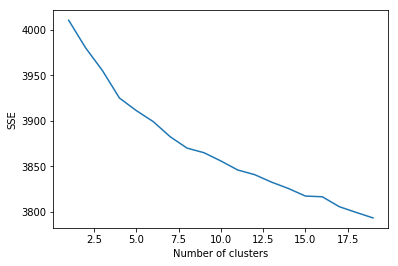

In [35]:
error = np.zeros(20)
for k in range(1,20):
    kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(X_normalized)
    error[k] = kmeans.inertia_

plt.plot(range(1, 20),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

In [124]:
kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=6, n_init=10, max_iter=300)  

# n_init: Number of time the k-means algorithm will be run 
# max_iter : int, default: 300

kmeans.fit_predict(X_normalized)

print ('\n Cluster Centroids')
centroids = kmeans.cluster_centers_
print (centroids)

print ('\nCluster labels')
kmeans_labels = kmeans.labels_
print(kmeans_labels)


print('\n')
error = kmeans.inertia_       #SSE; Sum of squared distances of samples to their closest cluster center.
print ("The total error of the clustering is: ", error)


 Cluster Centroids
[[-6.17133401e-03 -1.27255622e-02 -1.60816197e-02 ... -1.22325407e-03
  -6.02877606e-03 -1.42957700e-02]
 [ 1.16132837e+01 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]
 [-3.00190626e-02 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]
 [-3.00190626e-02 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]
 [-3.00190626e-02 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]
 [ 1.82159576e-01  4.82985343e-01  6.10043491e-01 ...  4.81854425e-02
   2.30491165e-01  5.43237237e-01]]

Cluster labels
[0 0 0 ... 0 0 0]


The total error of the clustering is:  67458204.74397254


In [125]:
print(kmeans.cluster_centers_)
asc_order_centroids = kmeans.cluster_centers_.argsort()    # argsort() returns the indices that would sort an array.
print(asc_order_centroids)

des_order_centroids = asc_order_centroids[:,::-1]     #  get the indices in descending order
print(des_order_centroids)

[[-6.17133401e-03 -1.27255622e-02 -1.60816197e-02 ... -1.22325407e-03
  -6.02877606e-03 -1.42957700e-02]
 [ 1.16132837e+01 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]
 [-3.00190626e-02 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]
 [-3.00190626e-02 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]
 [-3.00190626e-02 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]
 [ 1.82159576e-01  4.82985343e-01  6.10043491e-01 ...  4.81854425e-02
   2.30491165e-01  5.43237237e-01]]
[[1512 2948 1160 ... 2575 3976 1493]
 [2390 3879 1750 ... 1012 1400 1593]
 [2948 1512  665 ... 1487 1334 1545]
 [2306 2390  665 ... 3619  291 1665]
 [2948 1512  665 ... 1250 3013 3834]
 [1493 1449 3976 ... 1160 2948 1512]]
[[1493 3976 2575 ... 1160 2948 1512]
 [1593 1400 1012 ... 1750 3879 2390]
 [1545 1334 1487 ...  665 1512 2948]
 [1665  291 3619 ...  665 2390 2306

In [126]:
terms = vectorizer.get_feature_names()
for i in range(6):
    print ("Cluster:", i)
    for ind in des_order_centroids[i, :10]:
        print (terms[ind])
    print() 

Cluster: 0
heismanhouse
worldseries
nissanusa
flythew
netflix
strangerthings
gbbofinal
innovation
halloweencostume
gbbo

Cluster: 1
human
government
earth
power
movie
lying
violence
boycott
fire
banks

Cluster: 2
holiday
gifts
heart
vacation
toys
candy
mom
birthday
christmas
shopping

Cluster: 3
indiatoday
bdutt
timesnow
minhazmerchant
bjp4india
narendramodi
shekhargupta
digvijaya_28
manoharparrikar
karanjohar

Cluster: 4
vip
retweet
free
military
pink
fedex
veterans
fashion
follow
download

Cluster: 5
hillaryclinton
realdonaldtrump
fbi
jasoninthehouse
kellyannepolls
washingtonpost
cnn
kurteichenwald
donaldjtrumpjr
foxnews



In [61]:
ag = sk_cluster.AgglomerativeClustering(linkage='ward', n_clusters=6)   

#complete: The maximum distances
#n_clusters: The number of clusters to find.

ag_labels = ag.fit_predict(X_normalized)
ag_labels

array([0, 0, 0, ..., 0, 0, 0])